# STEP1 : Define Goal
##### - Make models that predict passengers survival chance in the titanic accident.
##### - Practice and demonstration of the topics :

#### Data Visulation
- Pandas
- Matplotlib
- Seaborn

# STEP2 : Get Data
##### Import libraries, load train data from Kaggle (already train/test splitted).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, make_pipeline



from impyute.imputation.cs import mice
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix

org_titanic = pd.read_csv('./data/train.csv')

# STEP3: Preprocessing & Exploratory data analysis (EDA) 
##### Creating new features, cleaning and preprocessing, EDA 

In [2]:
# lowercase for feature names
org_titanic.columns = [i.lower() for i in org_titanic.columns]
# Copy original data 
main_df = org_titanic.copy()

## Extract new features

In [3]:
def title_name(df):
    '''
    Extract title and surname from 'name' feature.
    
    Rare titles are combined with common titles:
    - Mr.   = Dr.+Rev.+Don.
    - Mrs.  = Ms.+ Mme.
    - Miss. = Mlle.+Ms.(even not clear mariage status, more Miss. exist)
    - VIP   = Major.+Lady.+Sir.+Col.+the Countess.+Jonkheer. 
    '''    
    
    df['title'] = df['name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
    df['surname'] = df['name'].apply(lambda x: x.split(',')[0])            
    
    # Modify titles 
    df.loc[df['title'].isin(['Mme.']), 'title']                                               = 'Mrs.'
    df.loc[df['title'].isin(['Mlle.','Ms.']), 'title']                                        = 'Miss.'
    df.loc[df['title'].isin(['Dr.', 'Rev.', 'Don.']), 'title']                                = 'Mr.'
    df.loc[df['title'].isin(['Major.', 'Lady.', 'Sir.', 'Col.', 'the', 'Jonkheer.']),'title'] = 'Vip.'
    
    print('Passenger titles: ', df['title'].unique())  
    return df

In [4]:
def define_groups(df):
    '''
    -Calculate (famsize) number of family members of all passengers. 
    -Also groupby 'Ticket' to group passengers as different approach.
    '''
    
    df['famsize'] = df['sibsp']+df['parch']+1    
    
    df['tic_grp']    = df.groupby('ticket')['ticket'].transform('count')

    return df

In [5]:
def prices(df):
    '''
    The tickets for multiple passengers show total price (It shown in Fare section). Calculate price per person for given fares. 
    (Assume that all families are on board and share same tickets! Can not calculate from 'fare' because data is alreadz train/test split)
    '''
    
    df['price'] = (df['fare'] / df['famsize']).astype('int64')
    
    return df

In [6]:
def age_groups(df):
    '''
    -Define passengers age groups: 'age_group'
    ''' 
    
    df['age_group'] = 0
    df.loc[(df['age'] >  8), 'age_group']                     = 1
    df.loc[(df['age'] >= 8)  & (df['age'] < 19), 'age_group'] = 2
    df.loc[(df['age'] >= 19) & (df['age'] < 51), 'age_group'] = 3
    df.loc[(df['age'] >= 51) & (df['age'] < 66), 'age_group'] = 4
    df.loc[(df['age'] >= 66),'age_group']                     = 5

    return df

In [7]:
main_df = title_name(main_df)
main_df = define_groups(main_df)
main_df = prices(main_df)

Passenger titles:  ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Vip.' 'Capt.']


## EDA: the Features

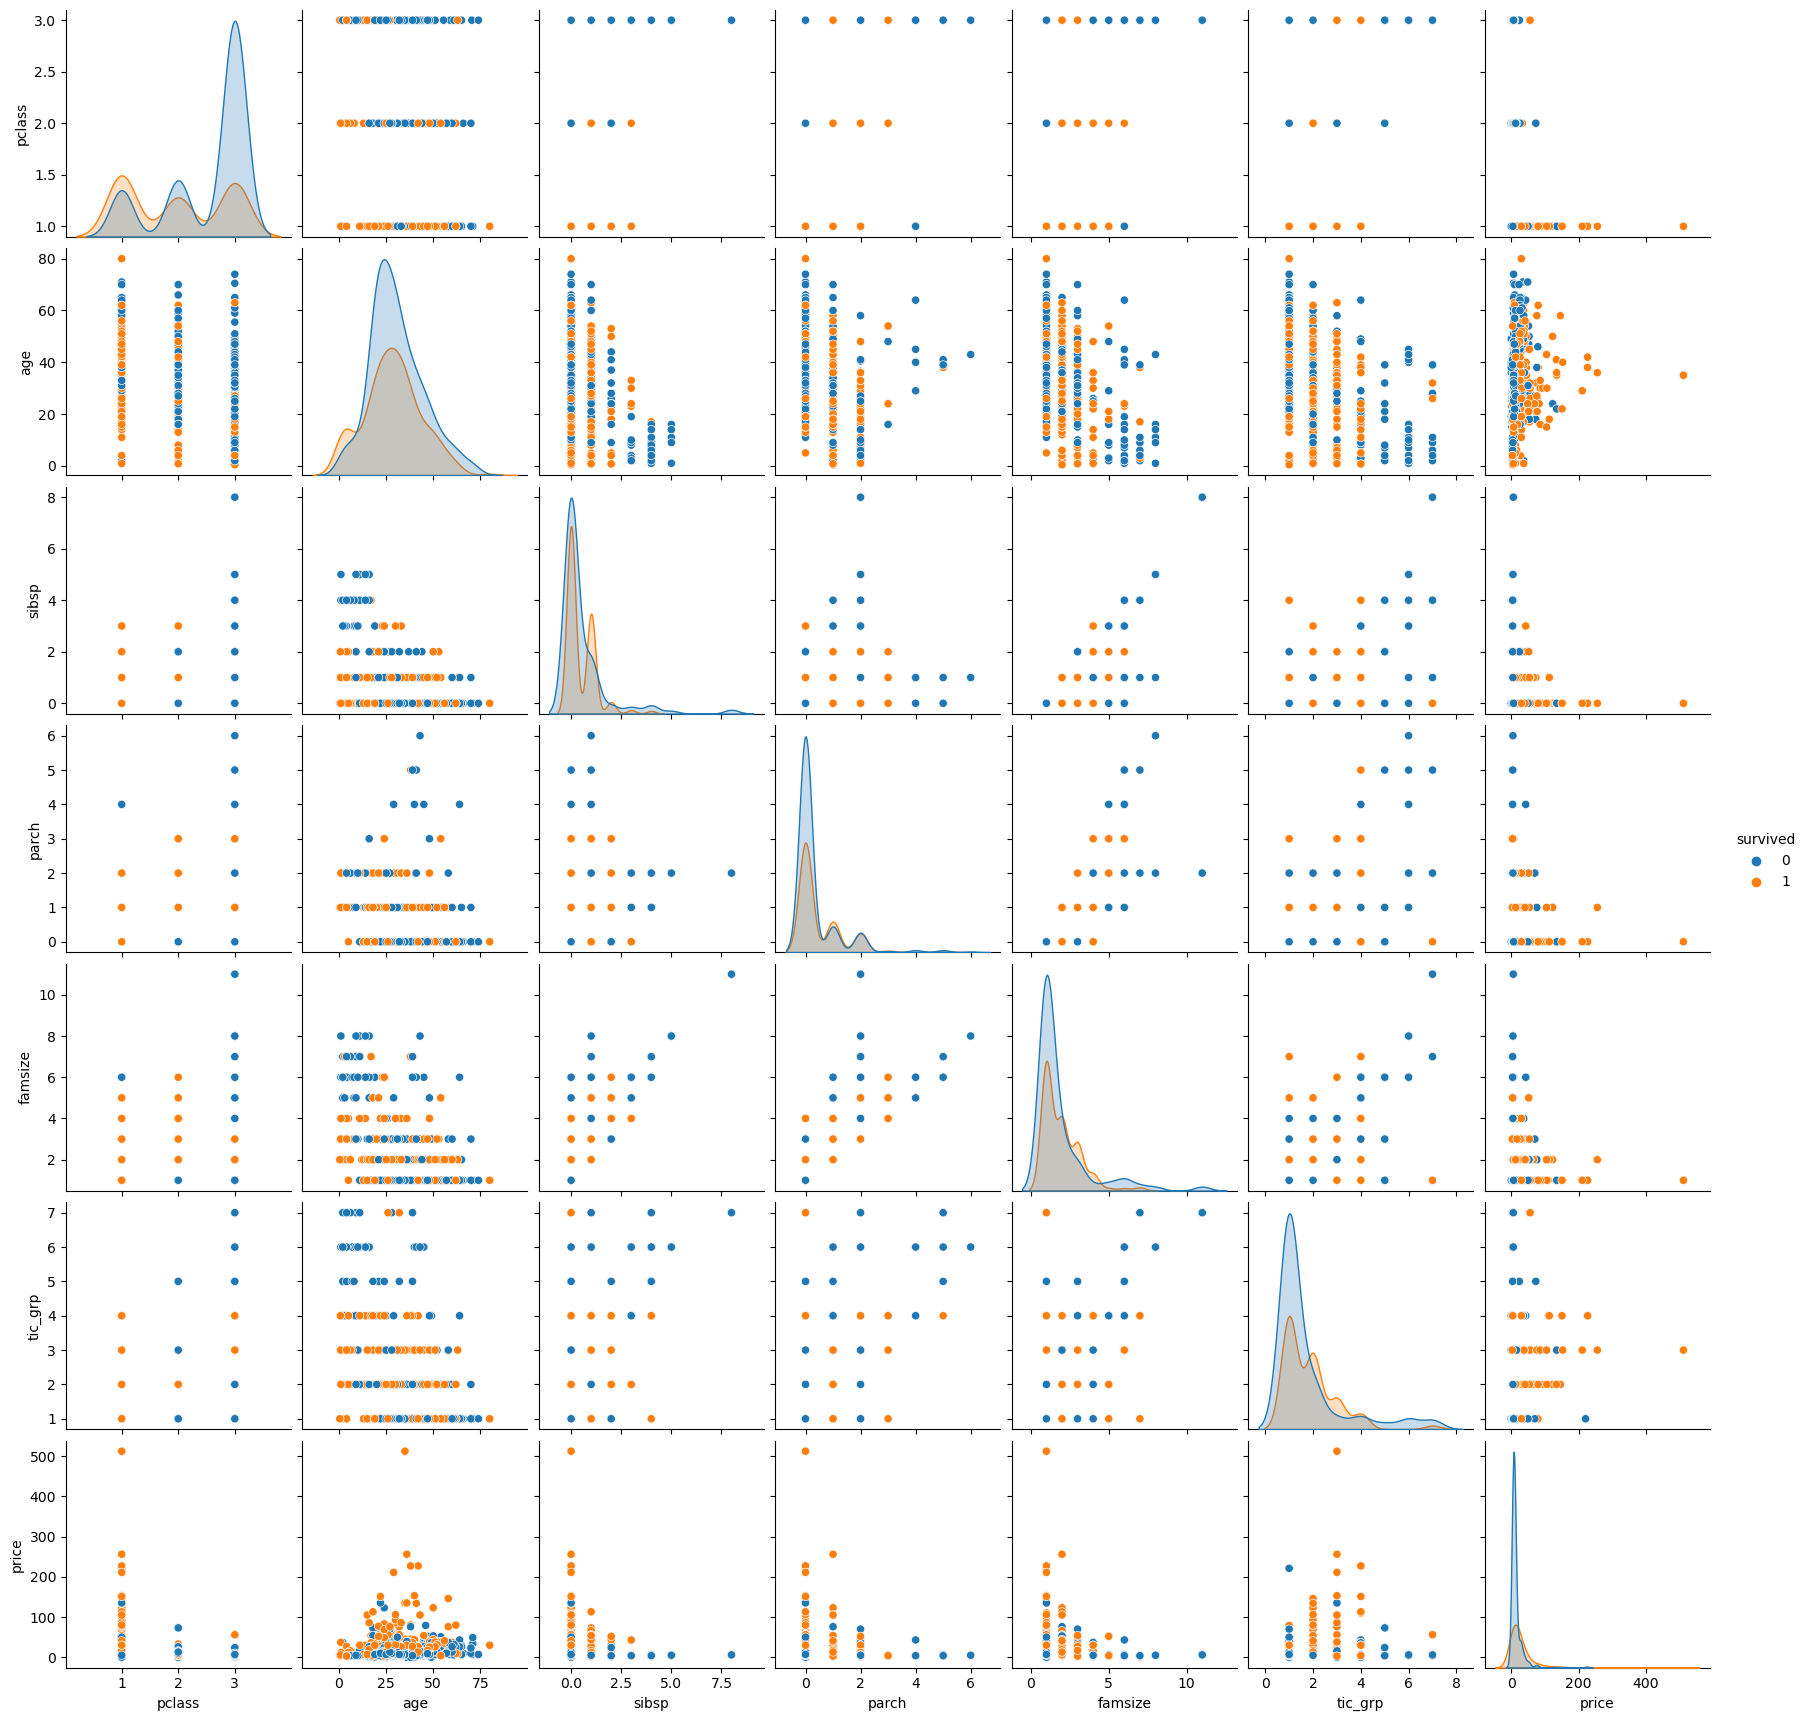

In [8]:
sns.pairplot(data=main_df.drop(columns=['passengerid','name', 'ticket', 'fare', 'cabin', 'surname']) , hue ='survived')

    **Survival  - Survival (0 = No; 1 = Yes). Not included in test.csv file.
    **pclass    - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    **name      - name
    **sex       - sex
    **age       - age
    **sibsp     - Number of Siblings/Spouses Aboard
    **parch     - Number of Parents/Children Aboard
    **ticket    - ticket Number
    **fare      - Passenger fare
    **Cabin     - Cabin
    **embarked  - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### **pclass**
#### **38%** of total passengers survived.

- **1st class :** **63%** of **216** 1st. passengers survived.
- **2nd class :** **47%** of **184** 2nd. passengers survived.
- **3rd class :** **24%** of **491** 3rd. passengers survived.

##### **embarked**
- **Southampton :** **34%** of **644** (from **1st**:20%, **2nd**:25%, **3rd**:55%) passengers survived.
- **Cherbourg :**   **55%** of **168** (from **1st**:51%, **2nd**:10%, **3rd**:39%) passengers survived.
- **Queenstown :**  **39%** of **77**  (from **1st**:3%, **2nd**:4%, **3rd**:94%) passengers survived.

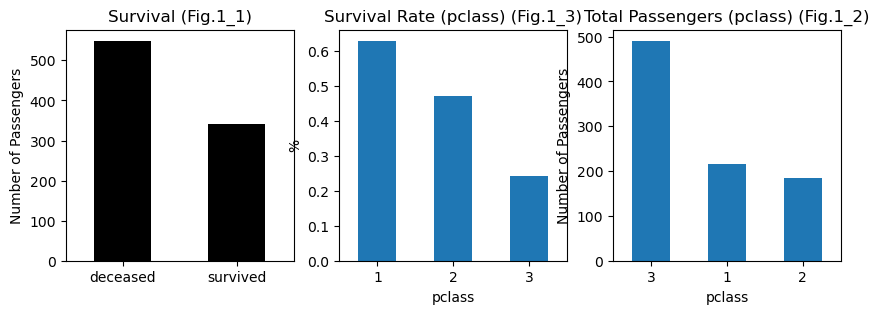

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))


main_df['survived'].replace(0, 'deceased').replace(1, 'survived').value_counts().plot(kind='bar',
                                                                                          color='black',
                                                                                          title='Survival (Fig.1_1)',
                                                                                          ylabel='Number of Passengers',
                                                                                          ax=axes[0],
                                                                                          rot=0)

main_df['pclass'].value_counts().plot(kind='bar',
                                                                          title='Total Passengers (pclass) (Fig.1_2)',
                                                                          xlabel='pclass',
                                                                          ylabel='Number of Passengers',
                                                                          ax=axes[2],
                                                                          rot=0)


main_df.groupby('pclass')['survived'].mean().plot(kind='bar',
                                                      title='Survival Rate (pclass) (Fig.1_3)',
                                                      ylabel='%',
                                                      xlabel='pclass',
                                                      rot=0,
                                                      ax=axes[1])

plt.show()

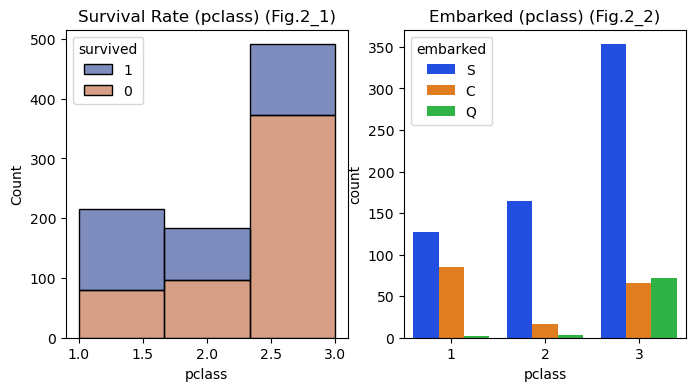

In [10]:
# plotting with seaborn
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=main_df,
             x='pclass',
             stat='count',
             hue='survived',
             palette='dark',
             hue_order=[1,0],
             alpha=0.5,
             bins=3,
             ax=axs[0],
             multiple="stack").set(title='Survival Rate (pclass) (Fig.2_1)')

sns.countplot(data=main_df,
            x='pclass', hue='embarked',
            palette='bright',
            alpha=1,
            ax=axs[1]).set(title='Embarked (pclass) (Fig.2_2)')

plt.show()

### **sex**
##### **Gender**
- **35%** of total **891** passengers are **female**.
- **74%** of **314 Female** (from **1st**:30%, **2nd**:24%, **3rd**:46%) passengers survived.
- **19%** of **577 Male**   (from **1st**:21%, **2nd**:19%, **3rd**:60%) passengers survived.

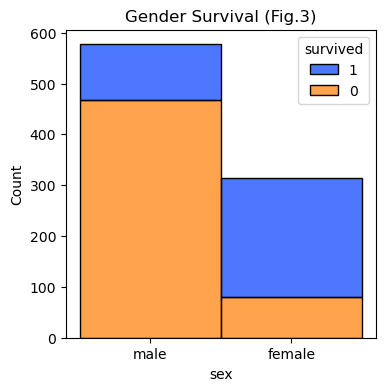

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
sns.histplot(data=main_df,
             x='sex',
             stat='count',
             hue='survived',
             palette='bright',
             hue_order=[1,0],
             alpha=0.7,
             bins=10,
             multiple="stack").set(title='Gender Survival (Fig.3)')
plt.show()

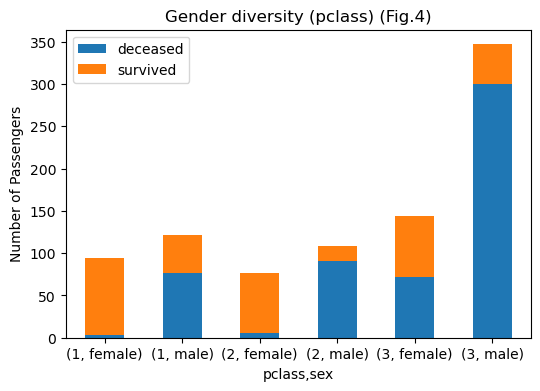

In [12]:
main_df.groupby(['pclass', 'sex','survived']).size().unstack().plot.bar(title='Gender diversity (pclass) (Fig.4)', 
                                                                 ylabel='Number of Passengers',
                                                                 rot=0,
                                                                 stacked=True,
                                                                 figsize=(6,4))
plt.legend(['deceased','survived'])
plt.show()

### **age**
##### **Survival Rate (age)** Fig.2_1 :
- Children (<8) : 0.68
- Youth (8-18) 0.40
- Adults (51-65): 0.39
- Seniors (>66) : 0.13

##### Deceased/survived age:
- Deceased median age: **Male** 29, **Female** 24
- survived median age: **Male** 28, **Female** 28

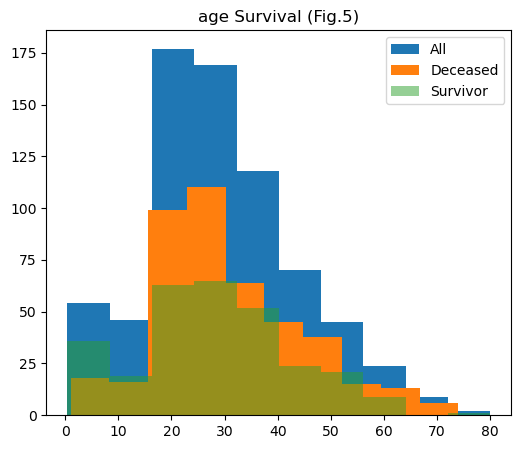

In [13]:
main_df.loc[:,'age'].hist()
main_df.loc[main_df['survived'] == 0, 'age'].hist()
main_df.loc[main_df['survived'] == 1, 'age'].hist(alpha=0.5,
                                                          figsize=(6,5),
                                                          #bins=8,
                                                          grid=False).set(title='age Survival (Fig.5)')
plt.legend(['All', 'Deceased', 'Survivor'])
plt.show()

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(data=main_df, x="age", hue='survived', hue_order=[1,0],             kde=True, color="skyblue", bins=40, multiple="stack", ax=axs[0, 0]).set(title='age (Survival) (Fig.6_1)')
sns.histplot(data=main_df, x="age", hue='pclass',                                kde=True, color="olive",   bins=40, multiple="stack", ax=axs[0, 1]).set(title='age (pclass) (Fig.6_2)')
sns.histplot(data=main_df, x="age", hue='sex',      hue_order=['female','male'], kde=True, color="gold",    bins=40, multiple="stack", ax=axs[1, 0]).set(title='age (sex) (Fig.6_3)')
sns.histplot(data=main_df, x="age", hue='embarked', hue_order=['Q','C','S'],     kde=True, color="teal",    bins=40, multiple="stack", ax=axs[1, 1]).set(title='age (embarked) (Fig.6_4)')

[Text(0.5, 1.0, 'age (embarked) (Fig.6_4)')]

## EDA: New Features

    title    =  '**Mr.**', '**Mrs.**', '**Miss.**', '**Master.**', '**Capt.**', '**Vip.**': ('Major.','Lady.', 'Sir.', 'Col.', 'the Countess.', 'Jonkheer.')
    surname  =  Last name of passenger
    price    =  Ticket price per person
    famsize  =  Number of family members (sibsp+parch+1)
    tic_grp  =  Number of groups (groupby 'ticket')

### fare (price)

#### One can see from Fig.7_1-3 and calculations below that **fare** is not single ticket prices, but total price of the groups. 
###### *(Here calculating 'price' from 'ticket'.value_counts() would be better approach but our data already train-split from Kaggle, so we dont have full data!)*
Fig.7_1-3: '**fare**' has very broad distribution and big difference between prices that indicates 'fare' is prices not for a single passenger, but group price. Comparing with calculated '**price**' feature, as expected, distribution gets narrower and differences lesser.

#### Fig.7-4-6: See '**price**' distribution without outliners for classes. 
- Max prices are high for each Pclass. That can be speculated as there are differences in rooms quality/location (like having windows outside...) that **could effect survival chance**.
- There are passengers with **zero 'fare'**. Assumed as free-tickets since one of those has 'Jonkheer.' title.
- Comparing median of prices of different Pclasses: 2nd class tickes **double of 3rd** and 1st class **2.5 times of 2nd class**. 

In [15]:
df                 = main_df.dropna(subset=['age'])
df['age']          = df['age'].astype('int64')
df['age_survival'] = df.loc[df['pclass'] == 1].groupby('age')['survived'].mean()#.astype('int64')
df['age_survival']          = df['age_survival'].astype('int64')

sns.lineplot(data=df, x=df['age'], y=df['age_survival'] )
plt.show()
#main_df['ratio'] = main_df.groupby('age')['survived'].mean().astype('int64')
#main_df.sort_values('ratio')
#df['age_survival'] 

/tmp/ipykernel_16470/4003673667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age']          = df['age'].astype('int64')
/tmp/ipykernel_16470/4003673667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_survival'] = df.loc[df['pclass'] == 1].groupby('age')['survived'].mean()#.astype('int64')


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
fig3, ax3 = plt.subplots(nrows=1, ncols=6, figsize=(10,7))

for i in range(1, 4):
    ax3[i-1].boxplot([main_df.loc[(main_df['price'] != 0) & (main_df['pclass'] == i), 'fare']],
                     positions=[1], widths=0.6)

    ax3[i-1].boxplot([main_df.loc[(main_df['price'] != 0) & (main_df['pclass'] == i), 'price']],
                     positions=[2], widths=0.6)
    ax3[i-1].set_xticks([1, 2])
    ax3[i-1].set_xticklabels(['fare', 'price'])
    ax3[i-1].set_title(f'Class{i}.(Fig.7_{i})'.format(i))


for i in range(3, 6):
    ax3[i].boxplot(
        [main_df.loc[(main_df['price'] != 0) & (main_df['pclass'] == i-2), 'price']],
        positions=[1], widths=0.6, whis=[5, 95], showfliers=False)
    ax3[i].set_xticks([1])
    ax3[i].set_xticklabels(['price'])
    ax3[i].set_title(f'Class{i-2}.(Fig.7_{i+1})'.format(i-2))


plt.show()

In [ ]:
print('---------------------------------- fare:')
print('--------------- pclass 1:')
print('single ticket for one person:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==1)]['fare'].median())
print('multi ticket for one person:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==1)]['fare'].median())
print('--------------- pclass 2:')
print('single ticket for one person:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==2)]['fare'].median())
print('multi ticket for one person:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==2)]['fare'].median())
print('--------------- pclass 3:')
print('single ticket for one person:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==3)]['fare'].median())
print('multi ticket for one person:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==3)]['fare'].median())


print('---------------------------------- prices:')
print('--------------- pclass 1:')
print('single ticket:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==1)]['price'].median())
print('multi ticket:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==1)]['price'].median())
print('both', main_df.loc[(main_df['pclass'] ==1)]['price'].median())
print('--------------- pclass 2:')
print('single ticket:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==2)]['price'].median())
print('multi ticket:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==2)]['price'].median())
print('both', main_df.loc[(main_df['pclass'] ==2)]['price'].median())
print('--------------- pclass 3:')
print('single ticket:', main_df.loc[(main_df['famsize'] ==1) & (main_df['pclass'] ==3)]['price'].median())
print('multi ticket:', main_df.loc[(main_df['famsize'] !=1) & (main_df['pclass'] ==3)]['price'].median())
print('both', main_df.loc[(main_df['pclass'] ==3)]['price'].median())


### title

In [ ]:
print('Titles : ',main_df['title'].unique())

fig, axs = plt.subplots(2, 3, figsize=(17, 8))

sns.histplot(data=main_df.loc[main_df['title'].isin(['Mr.','Miss.','Mrs.','Master.'])], 
             x="title", hue='survived',
             color="skyblue", bins=4, 
             multiple="stack", ax=axs[0, 0]).set(title='title (Survival) (Fig.8_1)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Master.', 'Vip.', 'Capt.'])], 
             x="title", hue='survived',
             color="skyblue", bins=10, 
             multiple="stack", ax=axs[0, 1]).set(title='title (Survival) (Fig.8_2)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Mr.','Miss.','Mrs.','Master.'])], 
             x="title", hue='pclass',
             color="skyblue", bins=40, 
             multiple="stack", ax=axs[1, 0]).set(title='title (pclass) (Fig.8_3)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Master.', 'Vip.', 'Capt.'])], 
             x="title", hue='pclass',
             color="skyblue", bins=40, 
             multiple="stack", ax=axs[1, 1]).set(title='title (pclass) (Fig.8_4)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Mr.','Miss.','Mrs.','Master.'])], 
             x="age", hue='title', hue_order=['Master.', 'Mrs.', 'Miss.', 'Mr.'],
             color="skyblue", bins=30, 
             multiple="stack", ax=axs[0, 2]).set(title='age (title) (Fig.8_5)')

sns.histplot(data=main_df.loc[main_df['title'].isin(['Master.', 'Vip.', 'Capt.'])], 
             x="age", hue='title',
             color="skyblue", bins=80, 
             multiple="stack", ax=axs[1, 2]).set(title='age (title) (Fig.8_6)')
plt.show()

### famsize

In [ ]:
main_df.groupby(['pclass', 'famsize']).size().unstack().plot.barh(title='Family Size (pclass) (Fig.9)', 
                                                                 stacked=True,
                                                                 width=0.4,
                                                                 figsize=(12,8))

## Summary





dsda

### Calculations

In [ ]:
print('Average age of survived and Deceased Passengers :')
print(org_titanic.groupby(['survived','sex'])['age'].median().astype('int64'))
print('---------------------------------------------------------')
print('Survival Ratio in age groups :')
print('Children (<8) :', org_titanic.loc[org_titanic['age']<8]['survived'].mean())
print('Youth (8-18)', org_titanic.loc[(org_titanic['age']>=8) & (org_titanic['age']<19)]['survived'].mean())
print('Adults (51-65):',org_titanic.loc[(org_titanic['age']>=(19)) & (org_titanic['age']<(66))]['survived'].mean())
print('Seniors (>66) :', org_titanic.loc[org_titanic['age']>=66]['survived'].mean())

In [ ]:
print(round(org_titanic.groupby('pclass')['survived'].mean(),2))
print('---------------------------------------------------------')
print(round(org_titanic.groupby('pclass')['survived'].mean(),2))
print('---------------------------------------------------------')
print('Number of Passengers per pclass :')
print(org_titanic['pclass'].value_counts())
print('Survival Rate :', round(org_titanic['survived'].mean(),2))
print('---------------------------------------------------------')
print('Precentage of Total Passengers:')
print(round(org_titanic['pclass'].value_counts()/org_titanic['pclass'].count(),2))
print('---------------------------------------------------------')
print('Survival % per pclass :')
print(round(org_titanic.groupby('pclass')['survived'].mean(),2))

In [ ]:
print('Gender :')
print(org_titanic['sex'].value_counts())
print('---------------------------------------------------------')
print('Gender Survival % per pclass :')
print(round(org_titanic.groupby('sex')['survived'].mean(),2))
print('---------------------------------------------------------')
print(round(((org_titanic.groupby(['sex','pclass'])['passengerid'].count())/ (org_titanic.groupby(['sex'])['passengerid'].count())), 2))

In [ ]:
print('Survival(embarked) :')
print(round(org_titanic['embarked'].value_counts()))
print('-----------------------')
print(round(org_titanic.groupby('embarked')['survived'].mean(),2))
print('-----------------------')
print(round(((org_titanic.groupby(['embarked','pclass'])['passengerid'].count())/ (org_titanic.groupby(['embarked'])['passengerid'].count())), 2))

## Cleaning: Fill missing values

### Check missing & zero values
- **age** 173 missing values.
- In **Cabin** almost 75% data missing! Care to use!
- **embarked** has 2 missing values.
- **fare** has 15 **zero** values.

### Check unique values
- (**Passenger Id** vs **name**), **survived**, **pclass**, **sex**, **embarked**: unique values look OK.
- Some **ticket** numbers shared by more than one person.
- Max value of **sibsp** vs **parch** also fit to each other
- Some **Cabin** number did not specified for the passenger but the group. One can still assume the cabins are located close to each other. 
- **fare** looks like total price for the group ticket

In [ ]:
print(org_titanic.info())
sns.heatmap(org_titanic.isna())

In [ ]:
print(org_titanic.loc[org_titanic['fare'] == 0]['passengerid'].count(), ' fare is missing.')
sns.heatmap(org_titanic==0)

In [ ]:
org_titanic.nunique()

### Imputation

#### '**embarked**'

There are **two missing values** in embarked. The missing values belong to the ticket=113572. Similar serial_numbers belong to S and C. Mainly S ...
**So set them to 'S'**

In [ ]:
#main_df.sort_values('ticket')[29:51]
main_df.loc[main_df['embarked'].isna(), 'embarked'] = 'S'

#### '**age**'

#### Missing values is filled according to title of the passenger. Avarage ages for different title group:

In [ ]:
print('Median Age -', main_df.groupby('title')['age'].median().astype('int64'))
print('________________________________________________')

print('Titles with missing values : ', main_df.loc[main_df['age'].isna()]['title'].unique())
print('________________________________________________')

# To be sure that it is a good assumption:
print('(Missing)/(tit_total):')
print('Mr.: ',     round(119/517,2), ' Mrs.: ',    round(17/126,2), ' Miss.: ',   round(36/185,2), ' Master.: ', round(4/40,2), ' Dr.: ',     round(1/7,2))
# Highest for Mr. with 23%. Eventhough it is quite high, lets assume it is OK for our purpose.

In [ ]:
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax3.boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Mr.'], positions=[1], widths=0.6)
ax3.boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Miss.'], positions=[2], widths=0.6)
ax3.boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Mrs.'], positions=[3], widths=0.6)
ax3.boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Dr.'], positions=[4], widths=0.6)
ax3.boxplot(main_df['age'].dropna().loc[main_df['title'] == 'Master.'], positions=[5], widths=0.6)
plt.show()

#### Ampute missin 'age' values according to 'title' :

## Preprocessing: Pipeline

In [ ]:
feature_transform = ColumnTransformer(
    transformers=[
        #("num", num_pipe, ['age', 'fare']),
        #("cat", cat_pipe, ['pclass', 'embarked', 'parch']),
        ("name", FunctionTransformer(title_name), ['name'])
        #("do_nothing", 'passthrough', ['sibsp'])
    ]

)#remainder='passthrough', 'drop'

# STEP4: Modeling

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(main_df.corr().abs(), annot=True) 
# We only care absolute values, not vector direction: abs()
# annot for the written values